In [38]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import scipy.io.wavfile
import wave

# Source wav file visualization in time and frequency domain

In [39]:
# Audio file containes speech plus 2 frequency spikes.
file_source_wav = "./audio_with_spikes.wav"
audio_source_rate, audio_source_data = scipy.io.wavfile.read(file_source_wav)
print("rate: {}, length: {:.3f}sec, number of channels: {}".format(audio_source_rate,
                    audio_source_data.shape[0]/audio_source_rate, len(audio_source_data.shape)))

rate: 44100, length: 3.039sec, number of channels: 1


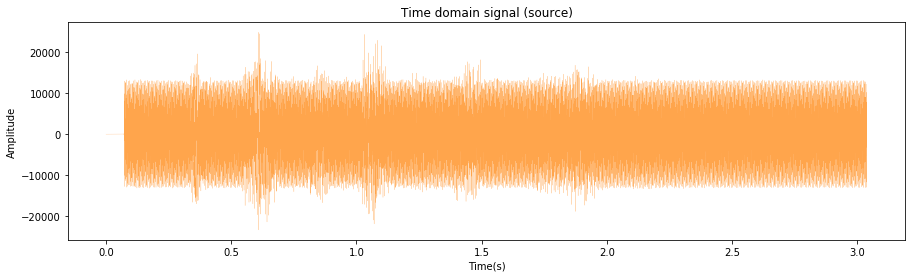

In [40]:
audio_time = np.arange(0, float(audio_source_data.shape[0]), 1) / audio_source_rate
plt.figure(figsize=(15, 4))
plt.plot(audio_time, audio_source_data, linewidth=0.2, alpha=0.7, color='#ff7f00')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title('Time domain signal (source)')
plt.show()

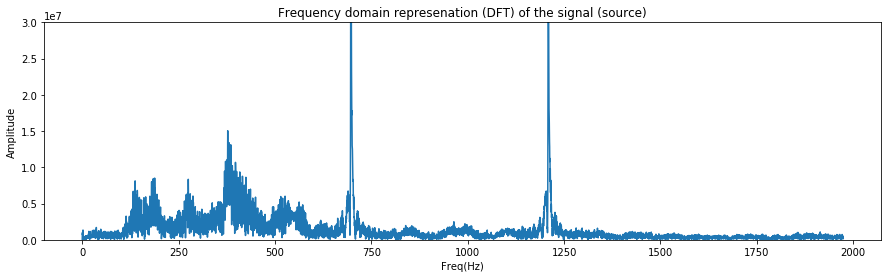

In [44]:
# Signal DFT has 44100 bins, but we are interested only in the lower band, including the spikes
FOURIER_SHOW_BINS = 6000
fourier_source = np.fft.fft(audio_source_data)

plt.figure(figsize=(15, 4))
fourier_source_freqs = np.arange(0, audio_source_data.shape[0]) * audio_source_rate / audio_source_data.shape[0]
plt.plot(fourier_source_freqs[:FOURIER_SHOW_BINS], np.abs(fourier_source[:FOURIER_SHOW_BINS]))
plt.xlabel('Freq(Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency domain represenation (DFT) of the signal (source)')
axes = plt.gca()
axes.set_ylim([0, +3e7])
plt.show()

# Filter design

In [42]:
from scipy.signal import kaiserord, lfilter, firwin, freqz

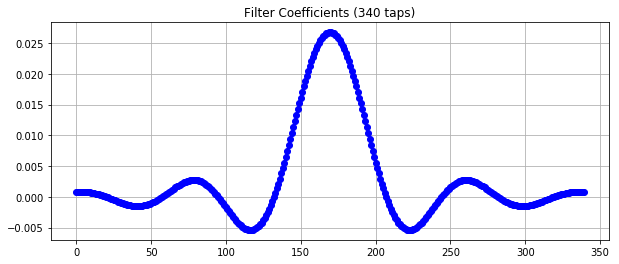

In [45]:
# The Nyquist rate of the signal.
audio_nyq_rate = audio_source_rate / 2.0

# The desired width of the transition from pass to stop, relative to the Nyquist rate.
# We'll design the filter with a 200 Hz transition width.
trans_width = 200.0 / audio_nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 30.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, trans_width)

# The cutoff frequency of the filter.
cutoff_hz = 590.0

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = firwin(N, cutoff_hz/audio_nyq_rate, window=('kaiser', beta))

# Plot the FIR filter coefficients.
plt.figure(figsize=(10, 4))
plt.plot(taps, 'bo-', linewidth=2)
plt.title('Filter Coefficients (%d taps)' % N)
plt.grid(True)
plt.show()

# Save the FIR filter coefficients.
f_w = open("fir_filter_coeffs", "w")
for coeff in taps:
    f_w.write(str(coeff) + '\n')
f_w.close()

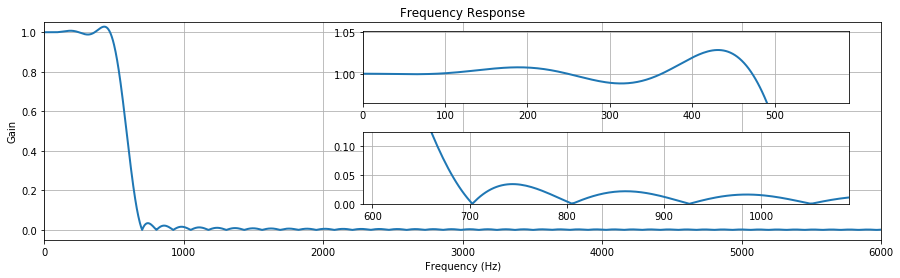

In [47]:
# Plot the magnitude response of the filter.
plt.figure(figsize=(15, 4))
plt.clf()
w, h = freqz(taps, worN=8000)
plt.plot((w / np.pi) * audio_nyq_rate, np.absolute(h), linewidth=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Frequency Response')
plt.xlim(0, 6000)
plt.ylim(-0.05, 1.05)
plt.grid(True)

# Upper inset plot.
ax1 = plt.axes([0.42, 0.6, .45, .25])
plt.plot((w / np.pi) * audio_nyq_rate, np.absolute(h), linewidth=2)
plt.xlim(0, cutoff_hz)
plt.ylim(0.965, 1.051)
plt.grid(True)

# Lower inset plot
ax2 = plt.axes([0.42, 0.25, .45, .25])
plt.plot((w / np.pi) * audio_nyq_rate, np.absolute(h), linewidth=2)
plt.xlim(cutoff_hz, cutoff_hz + 500)
plt.ylim(0.0, 0.125)
plt.grid(True)


# Filter applied to source signal

In [48]:
# Apply filter to source signal.
audio_filtered_data = lfilter(taps, 1.0, audio_source_data)
audio_filtered_data = audio_filtered_data.astype(np.int16)

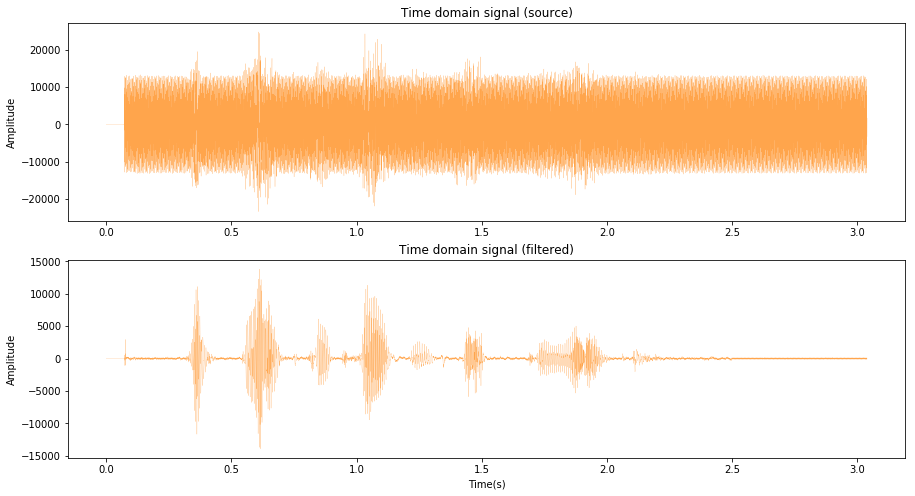

In [49]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(audio_time, audio_source_data, linewidth=0.2, alpha=0.7, color='#ff7f00')
plt.ylabel('Amplitude')
plt.title('Time domain signal (source)')
plt.subplot(2, 1, 2)
plt.plot(audio_time, audio_filtered_data, linewidth=0.2, alpha=0.7, color='#ff7f00')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title('Time domain signal (filtered)')
plt.show()

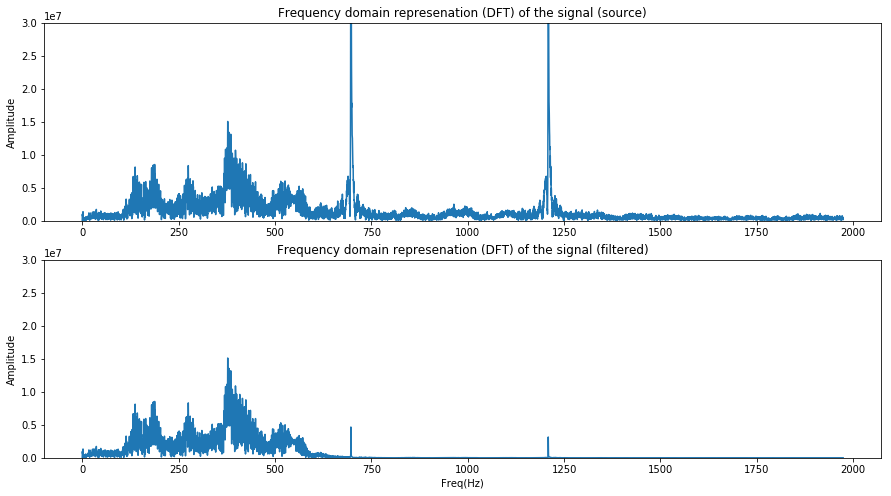

In [51]:
fourier_filtered = np.fft.fft(audio_filtered_data)

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(fourier_source_freqs[:FOURIER_SHOW_BINS], np.abs(fourier_source[:FOURIER_SHOW_BINS]))
plt.ylabel('Amplitude')
plt.title('Frequency domain represenation (DFT) of the signal (source)')
axes = plt.gca()
axes.set_ylim([0, +3e7])

plt.subplot(2, 1, 2)
plt.plot(fourier_source_freqs[:FOURIER_SHOW_BINS], np.abs(fourier_filtered[:FOURIER_SHOW_BINS]))
plt.xlabel('Freq(Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency domain represenation (DFT) of the signal (filtered)')
axes = plt.gca()
axes.set_ylim([0, +3e7])

plt.show()

# Audio filter operations

## Save the filtered wav data.

In [52]:
input_head, input_tail = os.path.split(input_file)
output_file = input_head + '/' + os.path.splitext(input_tail)[0] + '_filtered' + os.path.splitext(input_tail)[1]

f_w = wave.open(output_file, 'w')
f_w.setnchannels(1)
f_w.setsampwidth(2)
f_w.setframerate(audio_source_rate)
f_w.setnframes(audio_filtered_data.shape[0])
f_w.writeframes(audio_filtered_data)
f_w.close()

## Save the original wav data in text format.

In [53]:
input_head, input_tail = os.path.split(input_file)
output_file_text = input_head + '/' + os.path.splitext(input_tail)[0] + '.txt'

f_w = open(output_file_text, "w")
for samp in audio_source_data:
    f_w.write(str(samp) + '\n')
f_w.close()

## Load wav data in text format and compare to our filtered data.

In [58]:
input_head, input_tail = os.path.split(input_file)
processed_file = input_head + '/' + os.path.splitext(input_tail)[0] + '_proc.txt'

f_r = open(processed_file, 'r+')
audio_proc_list = [int(line) for line in f_r.readlines()]
f_r.close()

audio_proc_data = np.array(audio_proc_list).astype(np.int16)

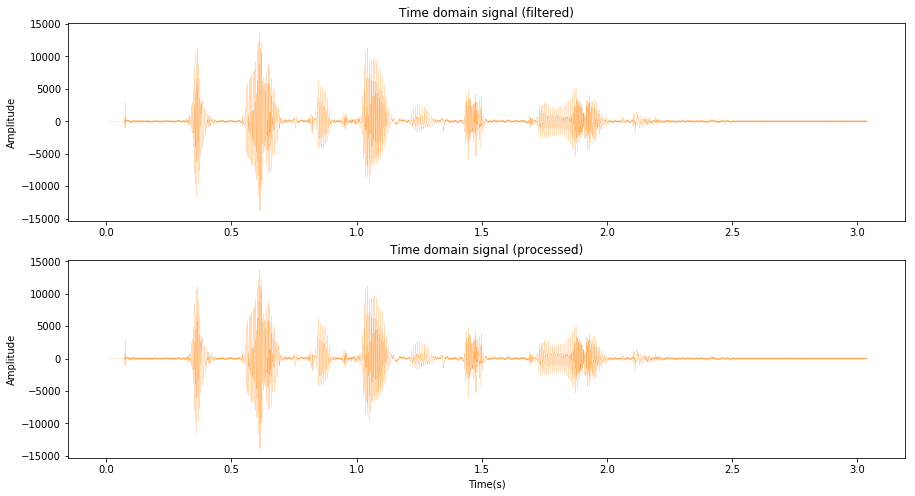

In [60]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(audio_time, audio_filtered_data, linewidth=0.2, alpha=0.7, color='#ff7f00')
plt.ylabel('Amplitude')
plt.title('Time domain signal (filtered)')
plt.subplot(2, 1, 2)
plt.plot(audio_time, audio_proc_data, linewidth=0.2, alpha=0.7, color='#ff7f00')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title('Time domain signal (processed)')
plt.show()

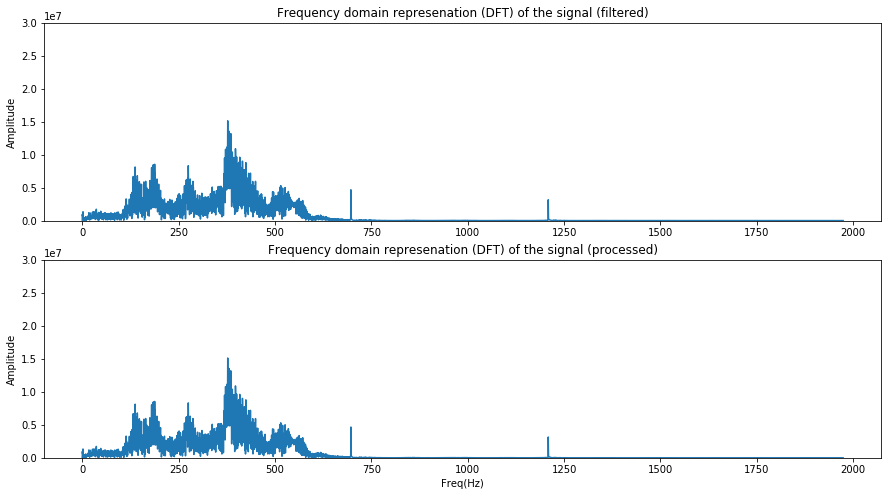

In [63]:
fourier_proc = np.fft.fft(audio_proc_data)

plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(fourier_source_freqs[:FOURIER_SHOW_BINS], np.abs(fourier_filtered[:FOURIER_SHOW_BINS]))
plt.ylabel('Amplitude')
plt.title('Frequency domain represenation (DFT) of the signal (filtered)')
axes = plt.gca()
axes.set_ylim([0, +3e7])

plt.subplot(2, 1, 2)
plt.plot(fourier_source_freqs[:FOURIER_SHOW_BINS], np.abs(fourier_proc[:FOURIER_SHOW_BINS]))
plt.xlabel('Freq(Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency domain represenation (DFT) of the signal (processed)')
axes = plt.gca()
axes.set_ylim([0, +3e7])

plt.show()